<a href="https://colab.research.google.com/github/kapitalistka/MLScannerApp/blob/master/Sberschool_Diplom_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializations

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.optim import lr_scheduler


from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')
%cd /
%cd /content/gdrive/MyDrive/ML/breeds

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/
/content/gdrive/MyDrive/ML/breeds


# EDA

In [11]:
#Read the dataset 
PATH = ''
labels = pd.read_csv('labels.csv')
labelnames = pd.read_csv('sample_submission.csv').keys()[1:]
print("Train folder has ", len(os.listdir('train')),'images which matches with label\'s', len(labels),'images')

codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

#Split to train and valid
train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print("Train shape is ", train.shape, ". Validation  shape is ", valid.shape)

Train folder has  10222 images which matches with label's 10222 images
Train shape is  (8689, 121) . Validation  shape is  (1533, 121)


#Data preparation

In [12]:
 # Image transformations
img_transform = {
    'valid':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size = 256),
        transforms.RandomRotation(degrees = 30),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'test':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

 # Train and valid dataset
class DogBreedDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_dir, label, transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = label

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.label)

    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            label = self.label.iloc[index, 1:].astype('float').to_numpy()
            label = np.argmax(label)
            if self.transform:
                image = self.transform(image)
            return [image, label]

batch_size = 16
num_workers = 8

train_img = DogBreedDataset('train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset('train/', valid, transform = img_transform['valid'])

dataloaders={
    'train' : torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle = True),
    'valid' : torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle = False)
}

#Model training


In [13]:
!pip install torchsummary

In [20]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

def train(n_epochs, loaders, model, optimizer, criterion, scheduler, name_for_save):
    valid_loss_min = np.Inf 

    VALID_LOSES = np.zeros((n_epochs,))
    TRAIN_LOSES = np.zeros((n_epochs,))
    ACCURACIES = np.zeros((n_epochs,))
    ACCURACIES_TRAIN = np.zeros((n_epochs,))
    
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        batch_counter = 0
        correct = 0
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            batch_counter += 1

            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            y_pred = output.max(1)[1].detach().cpu().numpy()
            correct_batch= np.mean(target.cpu().numpy() == y_pred)
            correct  += np.mean(target.cpu().numpy() == y_pred)
           
            if batch_idx % 100 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss))


        ACCURACIES_TRAIN[epoch - 1] = correct / batch_counter
        print(f"Train accuracy: { ACCURACIES_TRAIN[epoch - 1] }, batches count:  {batch_counter}")
 
        ######################    
        # validate the model #
        ######################

        model.eval()
        correct = 0
        batch_counter = 0  

        for batch_idx, (data, target) in enumerate(loaders['valid']):
            batch_counter += 1
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            y_pred = output.max(1)[1].detach().cpu().numpy()
            correct_batch= np.mean(target.cpu().numpy() == y_pred)
            correct  += np.mean(target.cpu().numpy() == y_pred)

        ACCURACIES[epoch - 1] = correct/batch_counter
        TRAIN_LOSES[epoch - 1] = train_loss
        VALID_LOSES[epoch - 1] = valid_loss

        # training/validation statistics 
        print(f'Validation Accuracy: {ACCURACIES[epoch - 1]}, batches count: {batch_counter}' )
        print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            filename = name_for_save + "{:.3f}".format(ACCURACIES[epoch - 1] * 100) + '_'+ epoch + '.pt'
            torch.save(model.state_dict(), filename)
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss  
        
        scheduler.step()

    # draw graphics   
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(ACCURACIES, label = "Validation accuracy" )
    plt.plot(ACCURACIES_TRAIN, label = "Train accuracy" )
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(VALID_LOSES, label = "Validation loss" )
    plt.plot(TRAIN_LOSES, label = "Train loss" )
    plt.legend()
          
    return model

# train the model
#model_scratch = train(10, dataloaders, model_scratch, optimizer, criterion,  'model_scratch.pt')

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))  

In [ ]:
##  Specify model architecture 
import torchvision
model_resnet = models.resnet50(pretrained = True)

# Freeze training for all "features" layers
for param in model_resnet.parameters():
    param.requires_grad = False
    
# replace the last fully connected layer with a Linnear layer 120 output
in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, 120)

model_resnet.to(device)

from torchsummary import summary
summary(model_resnet, input_size=(3, 224, 224))

In [22]:
criterion = nn.CrossEntropyLoss()
model_grad_parameters = filter(lambda p: p.requires_grad, model_resnet.parameters())
optimizer = torch.optim.SGD(model_grad_parameters, lr = 0.01, momentum = 0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.1)

Epoch: 1 	Batch: 1 	Training Loss: 4.815531
Epoch: 1 	Batch: 101 	Training Loss: 4.315544
Epoch: 1 	Batch: 201 	Training Loss: 3.685435
Epoch: 1 	Batch: 301 	Training Loss: 3.302519
Epoch: 1 	Batch: 401 	Training Loss: 3.058180
Epoch: 1 	Batch: 501 	Training Loss: 2.891833
Train accuracy: 0.3506433823529412, batches count:  544
Validation Accuracy: 0.7094851762820512, batches count: 96
Epoch: 1 	Training Loss: 2.8402 	Validation Loss: 0.9620
Validation loss decreased (inf --> 0.9620).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 1.798232
Epoch: 2 	Batch: 101 	Training Loss: 2.213635
Epoch: 2 	Batch: 201 	Training Loss: 2.098965
Epoch: 2 	Batch: 301 	Training Loss: 2.074819
Epoch: 2 	Batch: 401 	Training Loss: 2.054107
Epoch: 2 	Batch: 501 	Training Loss: 2.030387
Train accuracy: 0.5053998161764706, batches count:  544
Validation Accuracy: 0.7389823717948718, batches count: 96
Epoch: 2 	Training Loss: 2.0258 	Validation Loss: 0.9657
Epoch: 3 	Batch: 1 	Training Loss: 1.113284
Epo

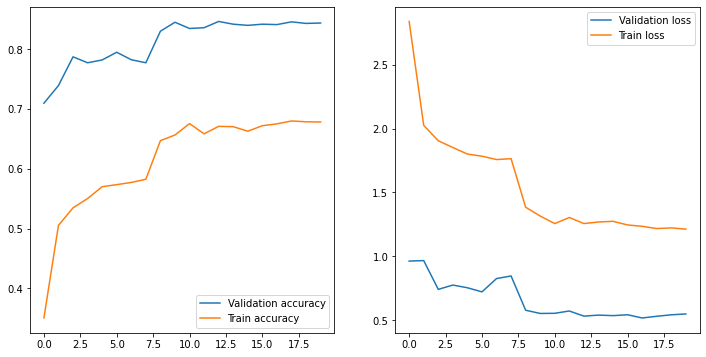

In [23]:
n_epochs = 20
model_transfer =  train(n_epochs, dataloaders, model_resnet, optimizer,  criterion, scheduler,'model_res')

#Model preparation for android

In [31]:
saved_model_for_mobile = "model_res84.605.pt"
android_model_file = "model9.pt"

In [32]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

#It's need to copy architecture of model
android_model = torchvision.models.resnet50(pretrained = True)

# Freeze training for all "features" layers
for param in android_model.parameters():
    param.requires_grad = False
    
# replace the last fully connected layer with a Linnear layer 133 output
in_features = android_model.fc.in_features
android_model.fc = nn.Linear(in_features, 120)

android_model.load_state_dict(torch.load(saved_model_for_mobile))

android_model.eval()

# optimization for mobile
example = torch.rand(1, 3, 224, 224)
traced_script_model = torch.jit.trace(android_model, example)
optimized_traced_model = optimize_for_mobile(traced_script_model)
optimized_traced_model._save_for_lite_interpreter(android_model_file)

#Predictions

In [28]:
saved_model_for_predict = "model_res84.605.pt"

In [ ]:
class DogBreedTestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir,  labels ,transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = labels

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            if self.transform:
                image = self.transform(image)
            return image


batch_size = 16
num_workers = 12

submission = pd.read_csv('sample_submission.csv')

test_img = DogBreedTestDataset('test/', submission, transform = img_transform['test'])

test_dataloader = torch.utils.data.DataLoader(test_img, batch_size, num_workers = num_workers, shuffle = False)


def predict(model, loader ):
  result = np.zeros((1, 120))

  for batch_idx, data in enumerate(loader):
    data = data.to(device)
    output = model(data)
    prob = F.softmax(output, dim = -1).cpu().detach().numpy()
    result = np.concatenate((result, prob), axis = 0)
    if batch_idx == 0:  
      result = np.delete(result, (0), axis=0)
    print(f"{batch_idx} / {len(loader)}" )

  return result 


import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

# restore model
restored_model = torchvision.models.resnet50(pretrained = True)

# Freeze training for all "features" layers
for param in restored_model.parameters():
    param.requires_grad = False
    
# replace the last fully connected layer with a Linnear layer 120 output
in_features = restored_model.fc.in_features
restored_model.fc = nn.Linear(in_features, 120)

restored_model.load_state_dict(torch.load( saved_model_for_predict ))

model = restored_model.to(device)

pred = predict(model, test_dataloader)
pred.shape

In [30]:
from numpy.core.multiarray import concatenate
columns = submission.columns.to_list()
columns.pop(0)

result_df = pd.DataFrame(data=pred, index=submission.id, columns=columns)
result_df.to_csv('result_submission.csv')

#pd.read_csv('result_submission.csv')